# Imports

In [1]:
import sys
import os
import random
import itertools
import h5py

import numpy as np
import pandas as pd
from PIL import Image

import plotly.offline as plotly
import plotly.graph_objs as go
import matplotlib
from matplotlib.pyplot import imshow
plotly.init_notebook_mode(connected=True)
matplotlib.rcParams['figure.figsize'] = [16, 16]

import tensorflow as tf
import sklearn.manifold as manifold
import sklearn.cluster as cluster
from learning_lib.nn.monitoring.loss import LossMonitor
from learning_lib.nn.cnn import CNN
from learning_lib.nn.autoencoder import convert_to_autoencoder

sys.path.insert(0,'..')
from datacollection.utils import generateFilePathStr

/home/fwang/anaconda3/envs/earth/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline

In [3]:
matplotlib.rcParams['figure.figsize'] = [16, 16]

# Problem Statement

This notebook is intended to investigate the ability for unsupervised methods to separate different macro features in satellite imagery.

# Basic Functions

In [4]:
image = 'LC80070522015173LGN00'
grid_size = 128
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'B10', 'B11']

In [5]:
def display_image(scene):
    image = Image.open(generateFilePathStr(scene, 'preproc', 'visible'))
    imshow(np.asarray(image))

In [6]:
def get_dataset(images, n, h5F):
    scene_list = []
    x_list = []
    y_list = []
    dataset = np.empty((
        len(images) * n,
        len(bands) * grid_size ** 2
    ))

    j = 0
    for sceneid in images:
        print("Generating sample for {}".format(sceneid))
        for _ in range(n):
            subimage = np.array(0)
            while (subimage == 0).any():
                dim = h5F[sceneid][bands[0]].shape
                subimage = np.empty((len(bands), grid_size, grid_size))
                x = random.randint(grid_size / 2, dim[0] - grid_size / 2 - 1)
                y = random.randint(grid_size / 2, dim[1] - grid_size / 2 - 1)

                for i, b in enumerate(bands):
                    subimage[i] = h5F[sceneid][b][
                        int(x - grid_size / 2) : int(x + grid_size / 2),
                        int(y - grid_size / 2) : int(y + grid_size / 2)
                    ]

            dataset[j] = subimage.flatten()
            scene_list.append(sceneid)
            x_list.append(x)
            y_list.append(y)
            j += 1
    
#     dataset = dataset.transpose((0, 2, 3, 1))
    reference_df = pd.DataFrame({
        'sceneid': scene_list,
        'x': x_list,
        'y': y_list
    })
    
    return dataset, reference_df

In [7]:
def color_image(sceneid, stride, grouping_function, flatten=True):
    image = np.array(Image.open(generateFilePathStr(sceneid, 'preproc', 'visible')))
    mask = np.zeros((image.shape[0] // stride, image.shape[1] // stride, 3), 'uint8')
    stride *= 2
    dim = (image.shape[0] * 2, image.shape[1] * 2)
    
    x_iterator = range(grid_size // 2, dim[0] - grid_size // 2, stride)
    y_iterator = range(grid_size // 2, dim[1] - grid_size // 2, stride)

    with h5py.File(generateFilePathStr(kind='database'), 'r') as h5F:

        batch_size = len(y_iterator)
        
        for i in x_iterator:
            dp = np.empty((batch_size, len(bands), grid_size, grid_size))
            
            for (j_index, j), (band_index, band) in itertools.product(
                enumerate(y_iterator),
                enumerate(bands)
            ):
                dp[j_index, band_index] = h5F[sceneid][band][
                    i - grid_size // 2 : i + grid_size // 2,
                    j - grid_size // 2 : j + grid_size // 2
                ]
                
#             dp = dp.transpose((0, 2, 3, 1))
            if flatten:
                dp = dp.reshape((batch_size, -1))
                
            groups = grouping_function(dp)
            
            mask[i // stride, np.array(y_iterator)[groups == 0] // stride, 0] = 255
            mask[i // stride, np.array(y_iterator)[groups == 1] // stride, 1]= 255
            mask[i // stride, np.array(y_iterator)[groups == 2] // stride, 2] = 255
            
    return mask

# KMeans

This block demonstrates that sampling only 1000 subimages from a landsat yields reasonable cloud/not-cloud separation using K-Means with k=2. This is true even for our image which is can also be naturally partitioned into 3 classes - clouds, water, and land.

In [54]:
images = ['LC80070522015173LGN00']
with h5py.File(generateFilePathStr(kind='database'), 'r') as h5F:
    data, reference_df = get_dataset(images, 1000, h5F)

Generating sample for LC80070522015173LGN00


In [55]:
km = cluster.KMeans(2)
cluster_labels = km.fit_predict(data[reference_df[reference_df['sceneid'] == 'LC80070522015173LGN00'].index])

In [57]:
%%time
sceneid = 'LC80070522015173LGN00'
grid_size = 128
image = np.array(Image.open(generateFilePathStr(sceneid, 'preproc', 'visible')))

with h5py.File(generateFilePathStr(kind='database'), 'r') as h5F:
    bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9']
    
    for i in range(1300,3000, 5):
        for j in range(4100, 5800, 5):
            dp = np.empty((len(bands), grid_size, grid_size))
            for k, b in enumerate(bands):
                dp[k] = h5F[sceneid][b][
                    int(i - grid_size / 2) : int(i + grid_size / 2),
                    int(j - grid_size / 2) : int(j + grid_size / 2)
                ]
                
            group = km.predict(dp.flatten().reshape((1, -1)))[0]
            
            if group == 0:
                image[i//2-1:i//2+2, j//2-1:j//2+2, 0] = 255
            elif group == 1:
                image[i//2-1:i//2+2, j//2-1:j//2+2, 1] = 255

CPU times: user 11min 35s, sys: 57.9 s, total: 12min 33s
Wall time: 12min 9s


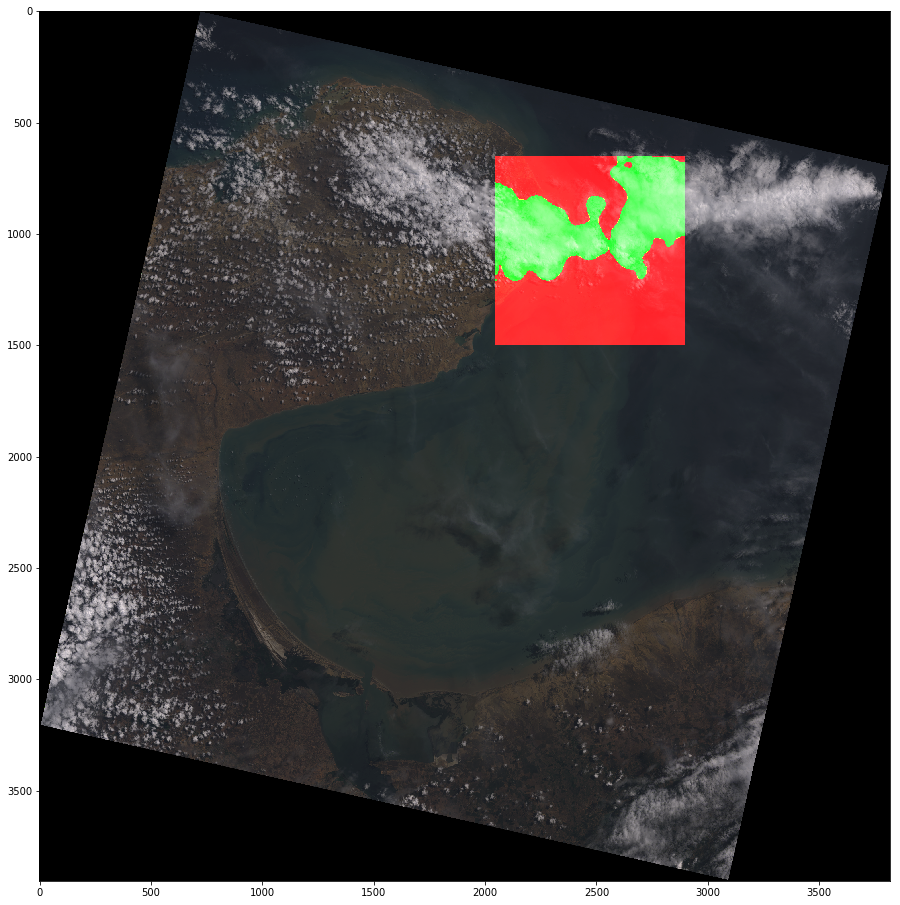

In [58]:
# 1000
imshow(np.asarray(image))

# 128x128 Autoencode Features

## Train

In [8]:
images = ['LC80070522015173LGN00']
grid_size = 128

with h5py.File(generateFilePathStr(kind='database'), 'r') as h5F:
    data, reference_df = get_dataset(images, 2000, h5F)
    
data = data.reshape((2000, len(bands), grid_size, grid_size)).transpose((0, 2, 3, 1)).astype('float32')
data = data / (2.0 ** 16) - 0.5

Generating sample for LC80070522015173LGN00


In [9]:
data_placeholder = tf.placeholder(tf.float32, data.shape)
d = tf.data.Dataset.from_tensor_slices((data_placeholder, data_placeholder))
d = d.batch(50)
d = d.shuffle(200)
iterator = d.make_initializable_iterator()
pipe_out = iterator.get_next()

In [10]:
lc = [
    {
        'layer_type': 'conv',
        'filter_size': [6, 6, 10, 32],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 2, 2, 1],
        'activation': tf.tanh,
        'output_size': [62, 62, 32]
    },
    {
        'layer_type': 'conv',
        'filter_size': [6, 6, 32, 32],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh,
        'output_size': [57, 57, 32]
    },
    {
        'layer_type': 'conv',
        'filter_size': [4, 4, 32, 32],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh,
        'output_size': [54, 54, 32]
    },
    {
        'layer_type': 'conv_transpose',
        'filter_size': [4, 4, 32, 32],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh,
        'output_size': [50, 57, 57, 32]
    },
    {
        'layer_type': 'conv_transpose',
        'filter_size': [6, 6, 32, 32],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh,
        'output_size': [50, 62, 62, 32]
    },
    {
        'layer_type': 'conv_transpose',
        'filter_size': [6, 6, 10, 32],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 2, 2, 1],
        'activation': tf.tanh,
        'output_size': [50, 128, 128, 10]
    }
]

In [11]:
monitors = [LossMonitor(200)]

In [12]:
cnn = CNN(
    lc, monitors=monitors, optimizer=tf.train.AdamOptimizer(),
    input_vector=pipe_out[0],
    train_targets_vector=pipe_out[1]
)
cnn.init_session()

In [ ]:
run_metadata = tf.RunMetadata()

In [17]:
cnn.session.run(iterator.initializer, feed_dict={data_placeholder: data})
cnn.session.run(
    cnn.output,
    feed_dict={data_placeholder: data},
    options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE),
    run_metadata=run_metadata
)

array([[[[-1.20776438e-03,  2.06042128e-03,  8.40073626e-04, ...,
           3.21768085e-03, -2.72677792e-03,  1.09692635e-04],
         [ 1.77388620e-02, -2.14473549e-02,  2.08485238e-02, ...,
           1.20512191e-02,  8.21388047e-03,  1.44856852e-02],
         [-1.56434695e-03, -1.21473204e-02, -1.28640430e-02, ...,
           1.52520766e-03, -6.41717203e-03,  9.08583775e-03],
         ...,
         [-9.72260628e-03,  1.25038940e-02, -1.89125966e-02, ...,
           3.78730777e-03,  6.68964582e-03,  6.69980189e-03],
         [ 1.03382871e-03,  1.79311971e-03,  7.59279355e-03, ...,
           1.72887219e-03, -6.69756997e-03, -9.78312735e-03],
         [ 3.12490831e-03,  6.69191312e-03, -1.83645189e-02, ...,
           1.74040403e-02, -1.11793652e-02, -1.08091778e-03]],

        [[-6.96958369e-03, -9.12988465e-03,  5.69967180e-03, ...,
           5.41386707e-03,  1.14414254e-02,  4.15256852e-03],
         [-1.37914065e-02,  6.27378514e-03,  5.95361507e-03, ...,
          -1.92636612e

In [19]:
from tensorflow.python.client.timeline import Timeline

In [20]:
trace = Timeline(step_stats=run_metadata.step_stats)

In [22]:
with open('timeline.ctf.json', 'w') as f:
    f.write(trace.generate_chrome_trace_format())

In [ ]:
run_metadata = tf.RunMetadata()
cnn.session.run(
    cnn.output,
    feed_dict={data_placeholder: data},
    options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
)

In [13]:
cnn = convert_to_autoencoder(cnn, 3)

In [ ]:
%%time
for epoch in range(300):
    cnn.session.run(iterator.initializer, feed_dict={data_placeholder: data})
    cnn.train_online()

In [23]:
plotly.iplot([go.Scatter(
    x=cnn.monitors[0].values['epochs'],
    y=cnn.monitors[0].values['loss'].ewm(alpha=0.01).mean()
)])

## TSNE

In [24]:
transformed_data = cnn.encode(data)

In [25]:
%%time
tsne = manifold.TSNE()
raw_embed = tsne.fit_transform(data.reshape((2000, -1)))

CPU times: user 29min 36s, sys: 26.4 s, total: 30min 3s
Wall time: 29min 33s


In [26]:
%%time
tsne = manifold.TSNE()
transformed_embed = tsne.fit_transform(transformed_data.reshape((2000, -1)))

CPU times: user 17min 41s, sys: 18.6 s, total: 18min
Wall time: 17min 42s


In [27]:
plotly.iplot([
    go.Scatter(
        x=raw_embed[:,0],
        y=raw_embed[:,1],
        mode='markers'
    )
])

In [28]:
plotly.iplot([
    go.Scatter(
        x=transformed_embed[:,0],
        y=transformed_embed[:,1],
        mode='markers'
    )
])

## Class Plots (K=3)

In [29]:
%%time
km = cluster.KMeans(3)
km.fit(data.reshape((2000, -1)))

def test_function(dp):
    dp = dp / (2.0 ** 16) - 0.5
    return km.predict(dp)
    
dp = color_image('LC80070522015173LGN00', 8, test_function)

CPU times: user 26min 26s, sys: 6min 44s, total: 33min 10s
Wall time: 32min 21s


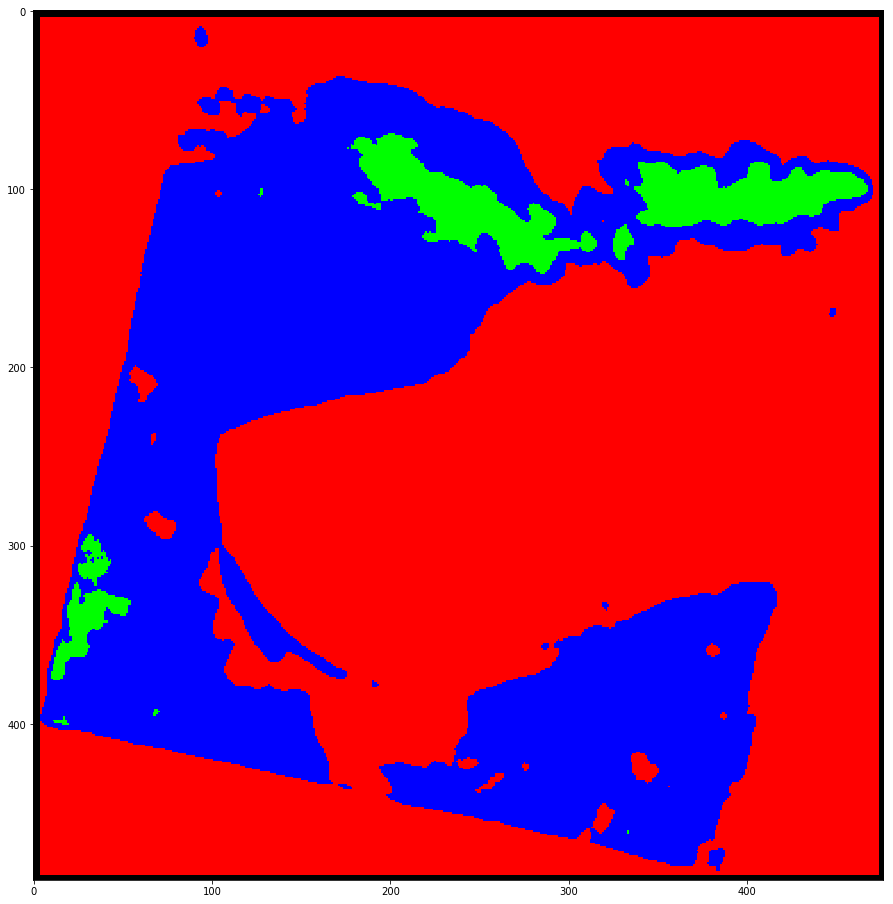

In [30]:
imshow(np.asarray(dp))

In [33]:
%%time
km = cluster.KMeans(3)
km.fit(transformed_data.reshape((2000, -1)))

def test_function(dp):
    dp = dp / (2.0 ** 16) - 0.5
    dp = dp.reshape((-1, len(bands), grid_size, grid_size))
    transformed_data = cnn.encode(dp.transpose((0, 2, 3, 1)))
    return km.predict(transformed_data.reshape((transformed_data.shape[0], -1)))
    
image = color_image('LC80070522015173LGN00', 8, test_function)

CPU times: user 27min 14s, sys: 10min 2s, total: 37min 16s
Wall time: 36min 27s


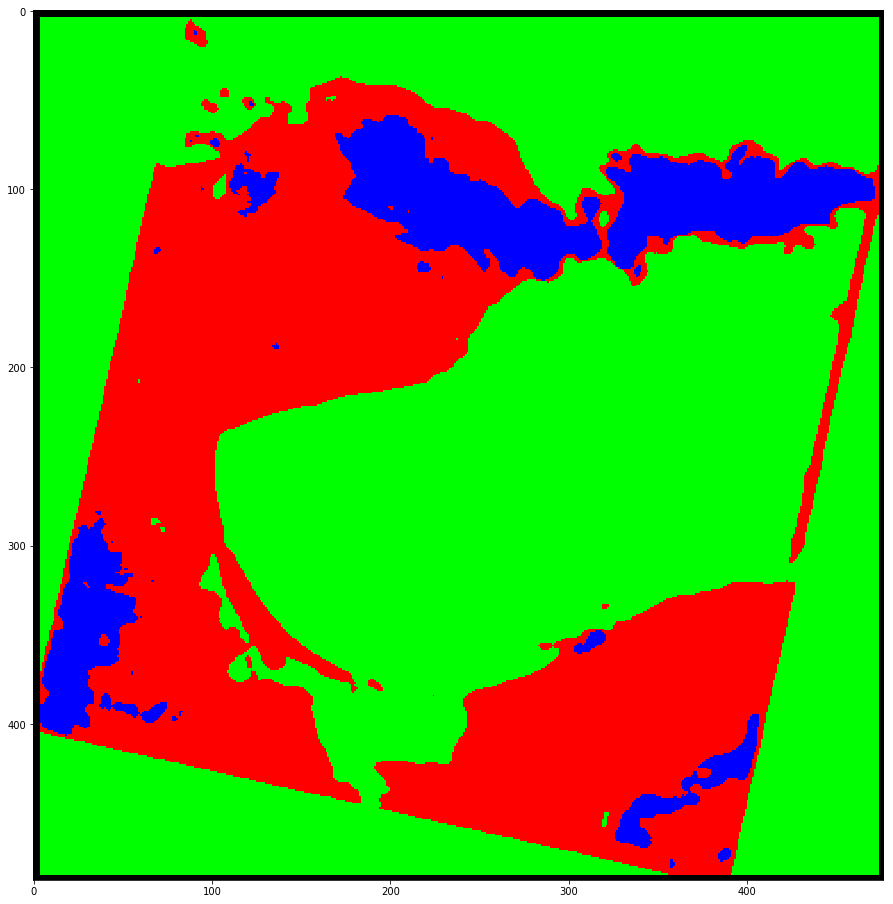

In [34]:
# 1000
imshow(np.asarray(image))

## Class Plots (K=2)

In [37]:
%%time
km = cluster.KMeans(2)
km.fit(data.reshape((2000, -1)))

def test_function(dp):
    dp = dp / (2.0 ** 16) - 0.5
    return km.predict(dp)
    
dp = color_image('LC80070522015173LGN00', 4, test_function)

CPU times: user 1h 41min 46s, sys: 25min 9s, total: 2h 6min 55s
Wall time: 2h 4min 32s


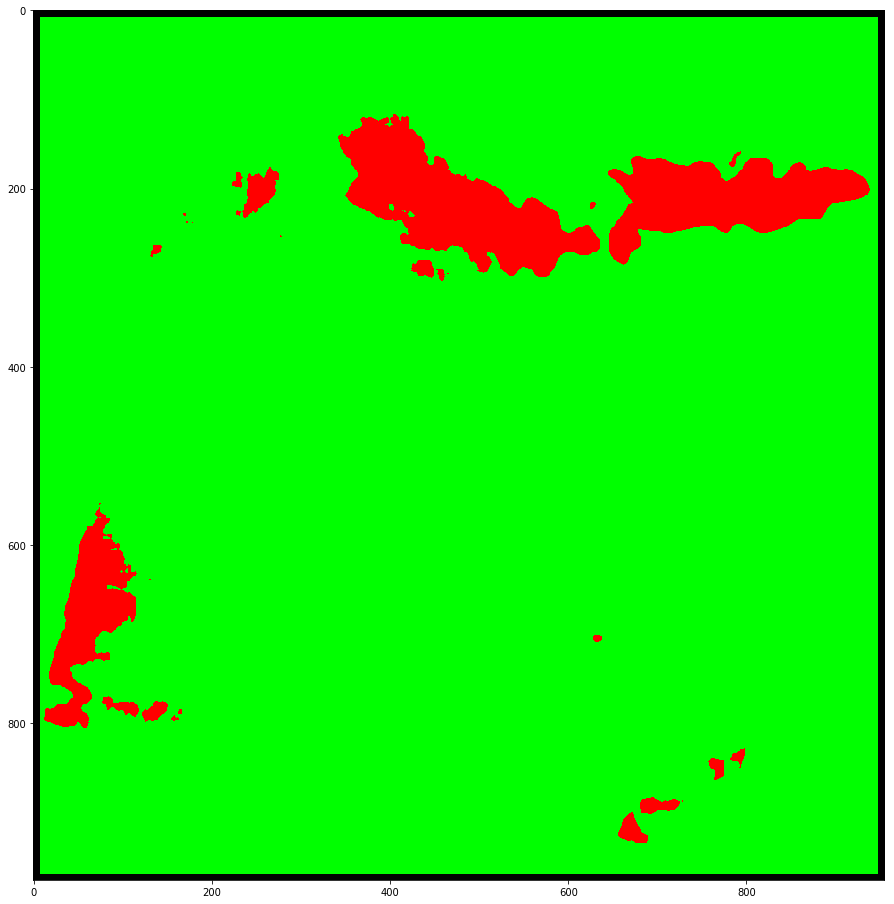

In [38]:
imshow(np.asarray(dp))

In [39]:
%%time
km = cluster.KMeans(2)
km.fit(transformed_data.reshape((2000, -1)))

def test_function(dp):
    dp = dp / (2.0 ** 16) - 0.5
    dp = dp.reshape((-1, len(bands), grid_size, grid_size))
    transformed_data = cnn.session.run(outp, feed_dict={inp: dp.transpose((0, 2, 3, 1))})
    return km.predict(transformed_data.reshape((transformed_data.shape[0], -1)))
    
image = color_image('LC80070522015173LGN00', 4, test_function)

KeyboardInterrupt: 

TypeError: Image data cannot be converted to float

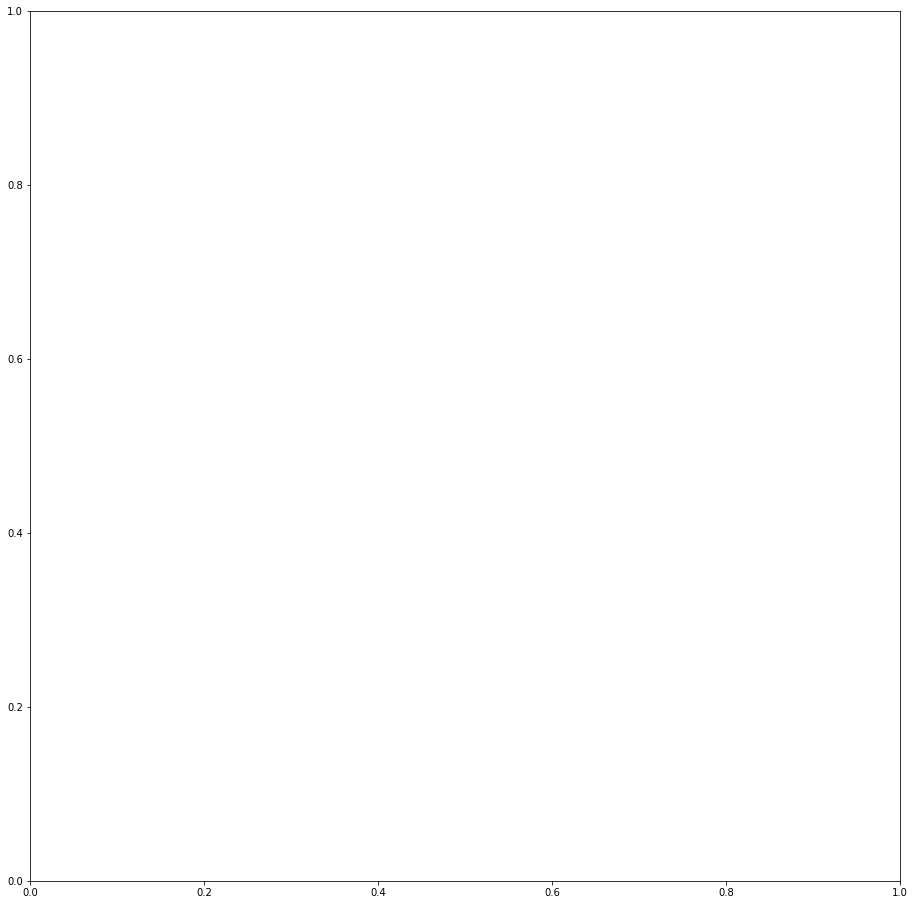

In [40]:
imshow(np.asarray(image))

In [38]:
raw_image = Image.open(generateFilePathStr('LC80070522015173LGN00', 'preproc', 'visible'))

In [36]:
from resizeimage import resizeimage

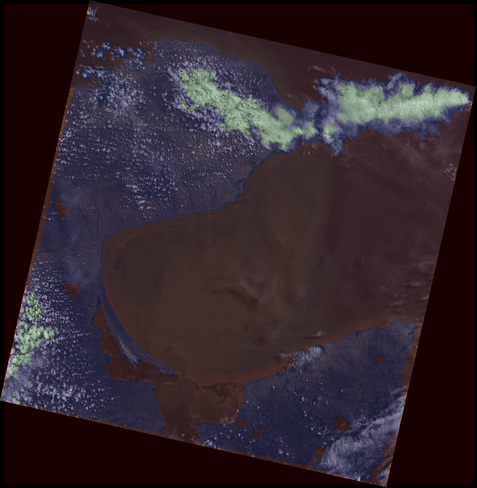

In [43]:
Image.fromarray((np.array(resizeimage.resize_cover(raw_image, (477, 488))) * 0.90 + dp * 0.10).astype('uint8'))

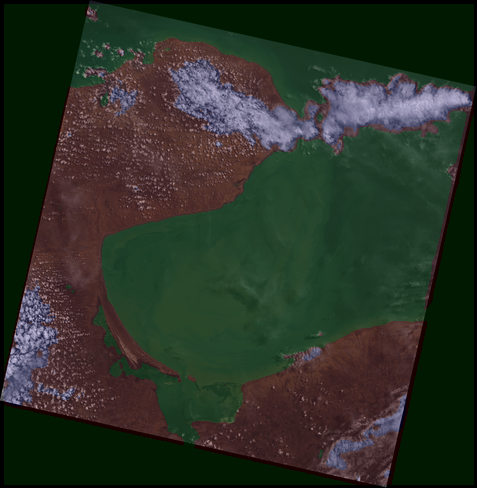

In [44]:
Image.fromarray((np.array(resizeimage.resize_cover(raw_image, (477, 488))) * 0.9 + image * 0.1).astype('uint8'))

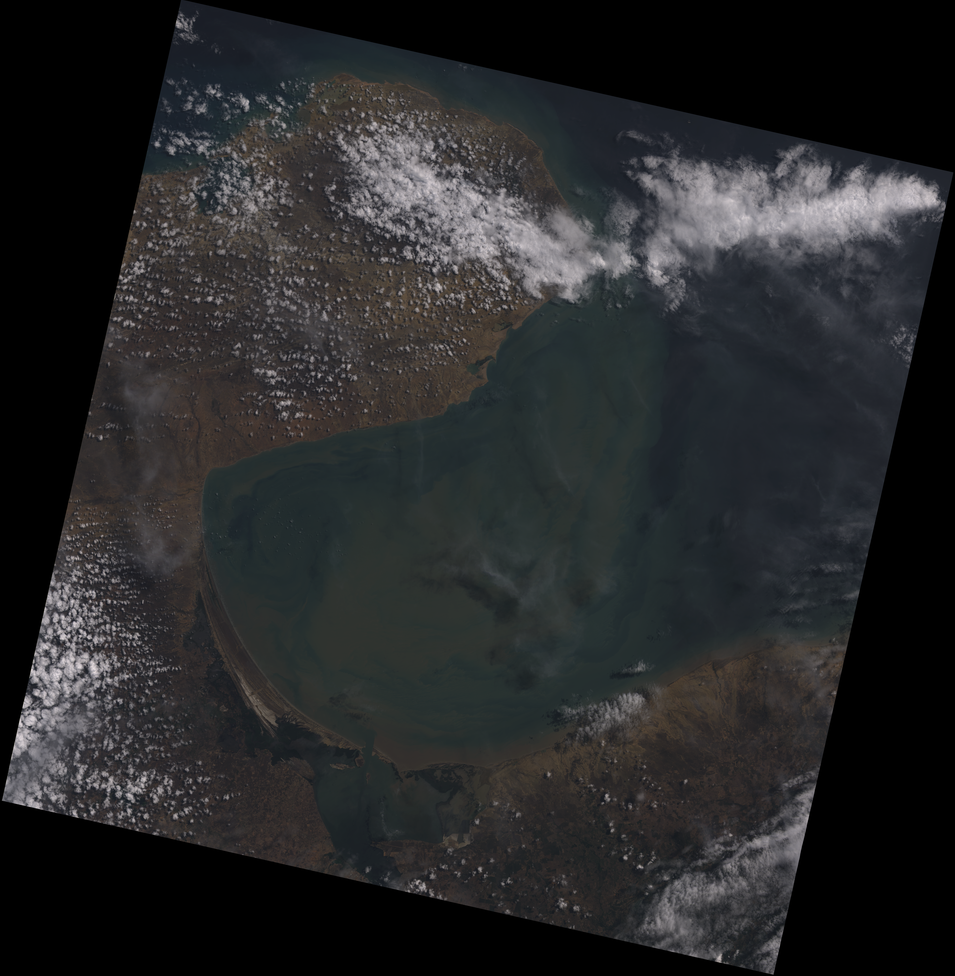

In [176]:
resizeimage.resize_cover(raw_image, (955, 976))

# 4x4 K-Means

## Train

In [61]:
images = ['LC80070522015173LGN00']
grid_size = 4

with h5py.File(generateFilePathStr(kind='database'), 'r') as h5F:
    data, reference_df = get_dataset(images, 2000, h5F)
    
data = data.reshape((2000, 10, 4, 4)).transpose((0, 2, 3, 1)).astype('float32')
data = data / (2.0 ** 16) - 0.5

Generating sample for LC80070522015173LGN00


## TSNE

In [63]:
tsne = manifold.TSNE()
raw_embed = tsne.fit_transform(data.reshape((2000, -1)))

In [64]:
plotly.iplot([
    go.Scatter(
        x=raw_embed[:,0],
        y=raw_embed[:,1],
        mode='markers'
    )
])

## Class Plots

In [62]:
%%time
km = cluster.KMeans(3)
km.fit(data.reshape((2000, -1)))

def test_function(dp):
    dp = dp / (2.0 ** 16) - 0.5
    return km.predict(dp)
    
dp = color_image('LC80070522015173LGN00', 4, test_function)

CPU times: user 1h 15min 22s, sys: 4min 51s, total: 1h 20min 13s
Wall time: 1h 16min 42s


In [112]:
dp_ = np.copy(dp)
image_ = np.copy(image)

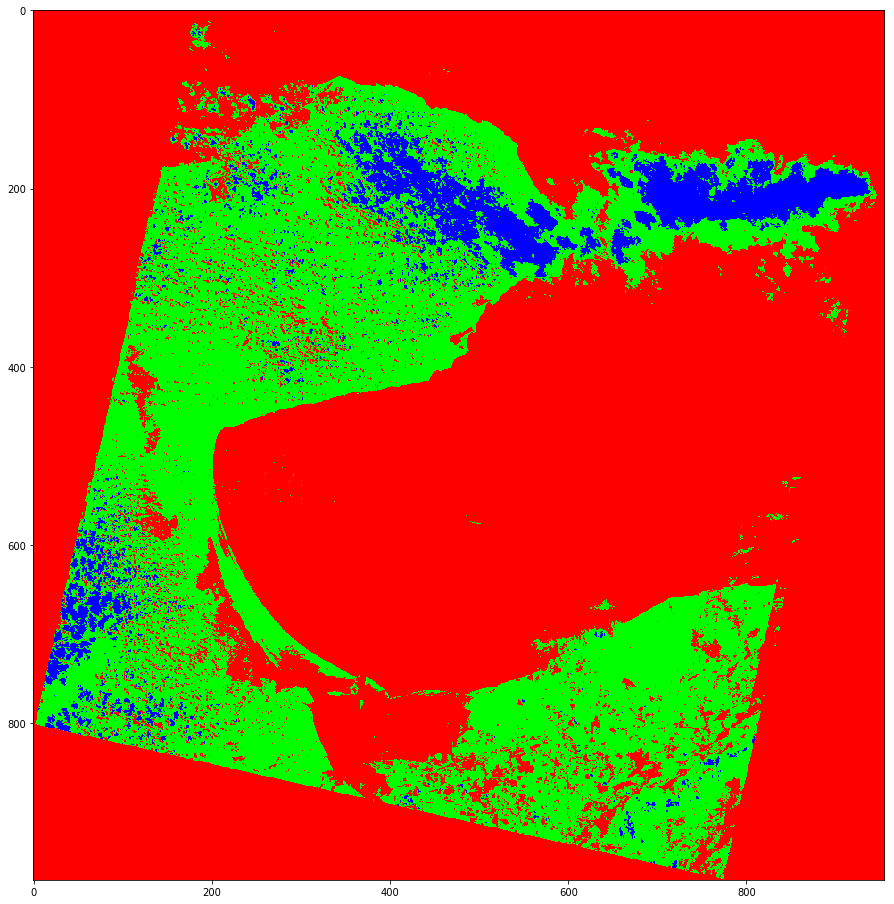

In [118]:
imshow(np.asarray(dp))

# B7 Threshhold

# Merge Autoencode and KMeans Masks

In [112]:
dp_ = np.copy(dp)
image_ = np.copy(image)

In [115]:
dp_[dp_[:,:,2] <= 0.9] = 0
image_[(image_[:,:,2] > 0.9) | (dp_[:,:,2] > 0.9)] = [0, 0, 255]
image_[(image_[:,:,2] <= 0.9) & (dp_[:,:,2] <= 0.9)] = 0

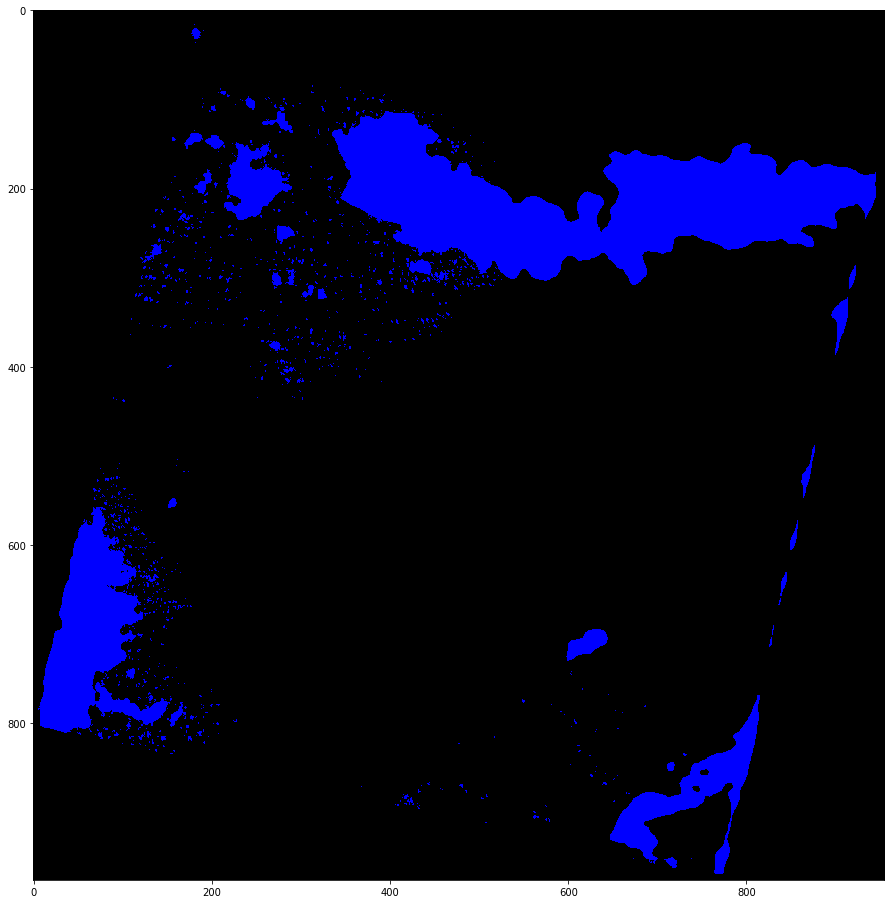

In [116]:
imshow(np.asarray(image_))